In [1]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
np. random. seed(0)
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[]


In [2]:

def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
n=1800
high_img = []
low_img = []
path = 'data/hr_images'
files = os.listdir(path)[:n]
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    img = cv2.imread(path + '/'+i,1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img_high = cv2.resize(img, (SIZE, SIZE))
    img_low = cv2.resize(img_high, (SIZE//4, SIZE//4))
    img_low = cv2.resize(img_low, (SIZE, SIZE))
    img_high = img_high.astype('float32') / 255.0
    img_low = img_low.astype('float32') / 255.0

    high_img.append(img_to_array(img_high))
    low_img.append(img_to_array(img_low))

100%|██████████| 1800/1800 [00:00<00:00, 2035.54it/s]


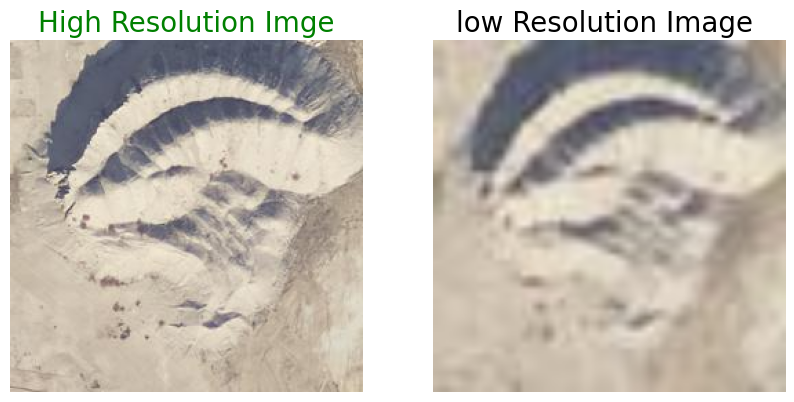

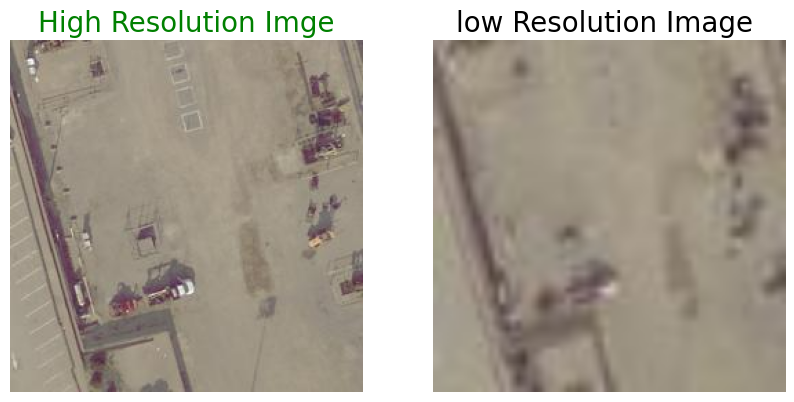

In [4]:
for i in range(2):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')


In [5]:
train_high_image = high_img[:3000]
train_low_image = low_img[:3000]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[3000:3600]
validation_low_image = low_img[3000:3600]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[3600:]
test_low_image = low_img[3600:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (800, 256, 256, 3)
Shape of test images: (100, 256, 256, 3)
Shape of validation images: (300, 256, 256, 3)


In [6]:
from keras import layers
from tensorflow.keras.utils import plot_model

input_img=Input(shape=(256,256,3))
l1=tf.keras.layers.Conv2D(64,9,padding='same',activation='relu') (input_img)
l2=tf.keras.layers.Conv2D(32,1,padding='same',activation='relu') (l1)
l3=tf.keras.layers.Conv2D(3,5,padding='same',activation='relu') (l2)

SRCNN=Model(input_img,l3)

def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )
SRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)
SRCNN.summary()
plot_model(SRCNN, to_file ='super_res.png',show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
SRCNN.fit(train_low_image, train_high_image, epochs = 20, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/20
800/800 [==============================] - ETA: 0s - loss: 0.0068

ResourceExhaustedError: Graph execution error:

SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;31c912cf5aaced14;/job:localhost/replica:0/task:0/device:GPU:0;edge_20_IteratorGetNext;0:0
	 [[{{node IteratorGetNext/_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_3168]

In [ ]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

In [ ]:
for i in range(16,25):
    predicted = np.clip(SRCNN.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('PSNR',PSNR(test_high_image[i],predicted),'dB', "SSIM",tf.image.ssim(test_high_image[i],predicted,max_val=1))

In [ ]:
from keras.models import load_model
# SRCNN.save("SRCNN_e_"+ "20" +".h5")
loadded_model = load_model('SRCNN_e_20.h5', compile=False)
for i in range(16,25):
    predicted = np.clip(loadded_model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('PSNR',PSNR(test_high_image[i],predicted),'dB', "SSIM",tf.image.ssim(test_high_image[i],predicted,max_val=1))